<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [34]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-27 13:45:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-08-27 13:45:02 (19.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [35]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [36]:
df.shape

(346, 10)

### Convert to date time object


In [37]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [38]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [39]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

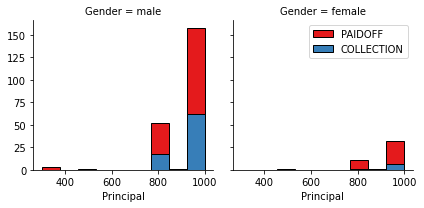

In [40]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

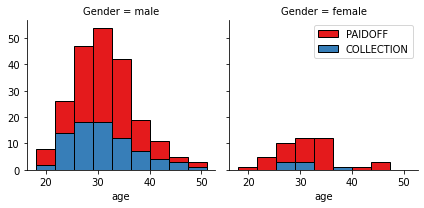

In [41]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


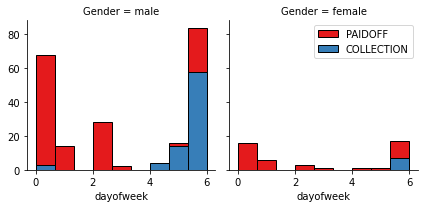

In [42]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [43]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [44]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [45]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [46]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [47]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [128]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender', 'dayofweek',
       'weekend'],
      dtype='object')

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [48]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [49]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Our Labels

We replace the categorical loan result variable with 0s and 1s.


In [50]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

In [51]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [52]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Training Data
All of the above data will be treated as training data.

In [94]:
#rename for readability and convention's sake
X_train, y_train = X, y

In [95]:
X_train.shape, y_train.shape

((346, 8), (346,))

In [96]:
# a dictionary for keeping all scores of the classifiers
trainScores={}

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


### Train-Test Split
To find the best value for k, we must split `train_loan.csv` into train and test data. To be thorough, this will be done using 10-fold cross validation. Then, we will evaluate the most accurate KNN model on `loan_test.csv`.

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# test k values from 0 to 14
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

#record the best cross validation score
best_score = 0.0

for k in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors=k, algorithm='auto')
    
    # using 10 fold cross validation for evaluating accuracy
    scores = cross_val_score(neigh, X_train, y_train, cv=10)
    score_mean = np.mean(scores)
    score_std = np.std(scores)
    
    mean_acc[k-1] = score_mean
    std_acc[k-1] = score_std
    
    # record the best KNN classifier
    if score_mean > best_score:
        best_score = score_mean
        best_knn = neigh
        best_k = k

print("Most accurate value for k is :",best_k,"| Cross validation Accuracy :",best_score)

neigh = best_knn

Most accurate value for k is : 7 | Cross validation Accuracy : 0.7438655462184873


### Plot cross validation accuracy for different number of neighbors

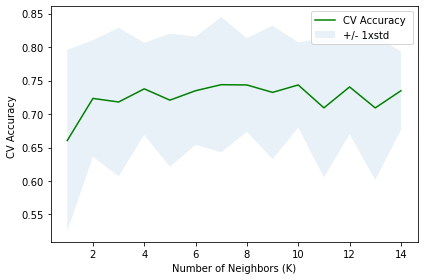

In [99]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('CV Accuracy ', '+/- 1xstd'))
plt.ylabel('CV Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Accuracy Evaluation

So, according to the 10-fold cross validation method, the most accurate KNN classifier uses a k of 7.

In [107]:
# evaluate the best KNN classifier on the training data and save the results
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

neigh.fit(X_train,y_train)
y_pred=neigh.predict(X_train)

trainScores['KNN-jaccard'] = jaccard_score(y_train, y_pred, pos_label=0)
trainScores['KNN-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [108]:
trainScores

{'KNN-jaccard': 0.7850162866449512, 'KNN-f1-score': 0.7955764876306204}

# Decision Tree


In [147]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf = tree_clf.fit(X_train, y_train)

y_pred= tree_clf.predict(X_train)

### Accuracy Evaluation

In [148]:
trainScores['Tree-jaccard'] = jaccard_score(y_train, y_pred, pos_label=0)
trainScores['Tree-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [149]:
trainScores

{'KNN-jaccard': 0.7850162866449512,
 'KNN-f1-score': 0.7955764876306204,
 'Tree-jaccard': 0.8724137931034482,
 'Tree-f1-score': 0.8870748695908691,
 'SVM-jaccard': 0.7717717717717718,
 'SVM-f1-score': 0.7180059052130698}

### Visualize the Tree

In [150]:
!pip install pydotplus
!pip install graphviz

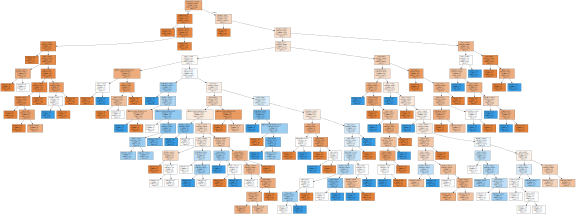

In [151]:
import graphviz 
import pydotplus
from io import StringIO
from sklearn import tree

dot_data = tree.export_graphviz(tree_clf,
                     feature_names=['Principal',
                                    'terms','age',
                                    'Gender',
                                    'weekend',
                                    'Bechalor',
                                    'High School or Below',
                                    'college',],
                     out_file=None, 
                     class_names= 'loan_status',
                     filled=True, 
                     special_characters=True,
                     rotate=False)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"8,8!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph

# Support Vector Machine


In [152]:
y_train=y_train.astype(float)

In [153]:
from sklearn import svm

svm_clf = svm.SVC(kernel='poly')
svm_clf.fit(X_train, y_train)  

y_pred = svm_clf.predict(X_train)

In [154]:
trainScores['SVM-jaccard'] = jaccard_score(y_train, y_pred, pos_label=0)
trainScores['SVM-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [155]:
trainScores

{'KNN-jaccard': 0.7850162866449512,
 'KNN-f1-score': 0.7955764876306204,
 'Tree-jaccard': 0.8724137931034482,
 'Tree-f1-score': 0.8870748695908691,
 'SVM-jaccard': 0.7717717717717718,
 'SVM-f1-score': 0.7180059052130698}

# Logistic Regression


In [161]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=0, solver='liblinear',)
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_train)
y_proba = log_clf.predict_proba(X_train)

In [162]:
from sklearn.metrics import log_loss

trainScores['LogReg-jaccard'] = jaccard_score(y_train, y_pred, pos_label=0)
trainScores['LogReg-f1-score'] = f1_score(y_train, y_pred, average='weighted')  
trainScores['LogReg-logLoss'] = log_loss(y_train, y_proba)

In [163]:
trainScores

{'KNN-jaccard': 0.7850162866449512,
 'KNN-f1-score': 0.7955764876306204,
 'Tree-jaccard': 0.8724137931034482,
 'Tree-f1-score': 0.8870748695908691,
 'SVM-jaccard': 0.7717717717717718,
 'SVM-f1-score': 0.7180059052130698,
 'LogReg-jaccard': 0.7447447447447447,
 'LogReg-f1-score': 0.6997291283105058,
 'LogReg-logLoss': 0.4339464601007741}

# Model Evaluation using Test set


First, download and load the test set:


In [166]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-27 16:42:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-27 16:42:39 (104 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [167]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preprocess Test Set

In [169]:
# convert to datetime objects
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#add day of week and weekend columns
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#one hot encode gender column
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#isolate feature set
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

y_test = y.astype(float)
X_test = preprocessing.StandardScaler().fit_transform(X)

In [170]:
testScores={}

In [173]:
#KNN
knn_pred = neigh.predict(X_test)
testScores['KNN-jaccard'] = jaccard_score(y_test, knn_pred, pos_label=0)
testScores['KNN-f1-score'] = f1_score(y_test, knn_pred, average='weighted')

In [174]:
#Decision Tree
tree_pred = tree_clf.predict(X_test)
testScores['Tree-jaccard'] = jaccard_score(y_test, tree_pred, pos_label=0)
testScores['Tree-f1-score'] = f1_score(y_test, tree_pred, average='weighted')

In [175]:
#SVM
svm_pred = svm_clf.predict(X_test)
testScores['SVM-jaccard'] = jaccard_score(y_test, svm_pred, pos_label=0)
testScores['SVM-f1-score'] = f1_score(y_test, svm_pred, average='weighted')

In [176]:
#Logistic Regression
log_pred = log_clf.predict(X_test)
proba = log_clf.predict_proba(X_test)
testScores['LogReg-jaccard'] = jaccard_score(y_test, log_pred, pos_label=0)
testScores['LogReg-f1-score'] = f1_score(y_test, log_pred, average='weighted')  
testScores['LogReg-logLoss'] = log_loss(y_test, proba)

In [183]:
#Training set accuracy metrics
trainScores

{'KNN-jaccard': 0.7850162866449512,
 'KNN-f1-score': 0.7955764876306204,
 'Tree-jaccard': 0.8724137931034482,
 'Tree-f1-score': 0.8870748695908691,
 'SVM-jaccard': 0.7717717717717718,
 'SVM-f1-score': 0.7180059052130698,
 'LogReg-jaccard': 0.7447447447447447,
 'LogReg-f1-score': 0.6997291283105058,
 'LogReg-logLoss': 0.4339464601007741}

In [184]:
#Test set accuracy metrics
testScores

{'KNN-jaccard': 0.7,
 'KNN-f1-score': 0.7001989201477693,
 'Tree-jaccard': 0.6938775510204082,
 'Tree-f1-score': 0.7105756358768406,
 'SVM-jaccard': 0.7307692307692307,
 'SVM-f1-score': 0.683127572016461,
 'LogReg-jaccard': 0.7547169811320755,
 'LogReg-f1-score': 0.6717642373556352,
 'LogReg-logLoss': 0.4791925061797864}

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.70       | 0.70        | NA      |
| Decision Tree      | 0.6939       | 0.7106        | NA      |
| SVM                | 0.7308       | 0.6831        | NA      |
| LogisticRegression | 0.7547       | 0.6718        | 0.4792       |


> The LogisticRegression model outperforms the others according to the Jaccard Score.